In [1]:
import glob, h5py, numpy
from pycbc.conversions import mchirp_from_mass1_mass2,chi_eff
from pycbc.sensitivity import volume_montecarlo,volume_to_distance_with_errors
from lal import YRJUL_SI as lal_YRJUL_SI

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# injection values

In [3]:
with h5py.File(
    '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/injhdf/inj_highspin_mass1p4_dist20_300.hdf','r') as f:
    injm1 = f['mass1'][:]
    injm2 = f['mass2'][:]
    injdist = f['distance'][:]
    injspin1z = f['spin1z'][:]
    injspin2z = f['spin2z'][:]
    
injmc = mchirp_from_mass1_mass2(injm1,injm2)
injchieff = chi_eff(injm1,injm2,injspin1z,injspin2z)

In [4]:
injm1

array([1.44146135, 1.43292728, 1.44562092, ..., 1.4468485 , 1.48729092,
       1.42450461])

In [5]:
injm2

array([1.44146135, 1.43292728, 1.44562092, ..., 1.4468485 , 1.48729092,
       1.42450461])

In [6]:
injspin1z

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [7]:
injspin2z

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

In [8]:
injchieff

array([ 0.9, -0.9,  0.5, ...,  0.9,  0.9, -0.1])

# Found and missed array, size = len(injection)

In [9]:
found_bool = numpy.zeros(len(injm1), dtype=bool)
found_ifarlt_bool = numpy.zeros(len(injm1),dtype=bool)
missed_bool = numpy.zeros(len(injm1), dtype=bool)

In [10]:
num_found = 0 
num_missed = 0

In [11]:
fnames = glob.glob(
    '/work/yifan.wang/search-high-spin/inj-t10-1p4spin0p9/runs/*/*/HIGHSPIN_coinc/*HDFINJFIND*.hdf')

In [12]:
len(fnames)

84

In [13]:
loundest_ifar = 1.01 #a constant
t = 0 #foreground time

for fname in fnames:
    f = h5py.File(fname, 'r')
    num_found += len(f['found/ifar_exc'])
    num_missed += len(f['missed/after_vetoes'])#after_vetoes: I think it means some injections are actually 
    #injected to veto times 'by accident', what one really cares about should be those 'within_analysis'
    #There is also an argument named 'within_analysis', which is identical to that of 'after_vetoes'
    
    ifar = f['found/ifar_exc'][:]
    #turn the found and missed indices to True
    injindex = f['found/injection_index'][:]
    injindex_ifarlt = injindex[numpy.where(ifar>=loundest_ifar)[0]]
    
    found_bool[injindex] = True
    found_ifarlt_bool[injindex_ifarlt] = True
    
    missindex = f['missed/after_vetoes'][:] # is this also indices??? Yes it is
    missed_bool[missindex] = True
    
    t += f.attrs['foreground_time_exc'] / lal_YRJUL_SI

In [14]:
found_bool.sum()

132955

In [15]:
found_ifarlt_bool.sum()

64356

In [16]:
num_found

132955

In [17]:
missed_bool.sum()

171851

In [18]:
num_missed

171851

# VT

In [19]:
np.unique(injchieff)

array([-0.9, -0.9, -0.9, -0.5, -0.1, -0.1,  0.1,  0.1,  0.5,  0.9,  0.9,
        0.9])

In [20]:
spin = numpy.array([-0.9,-0.5,-0.1,0.1,0.5,0.9])

In [22]:
volume = {}
num_total = 0
num_found = 0
num_missed = 0

realmissed_bool = (found_bool ^ found_ifarlt_bool) | missed_bool

for spinv in spin:
    region = np.isclose(injchieff,spinv) 
        
    found_dist = injdist[found_ifarlt_bool & region]
    missed_dist = injdist[realmissed_bool & region]
        
    found_mc = injmc[found_ifarlt_bool & region]
    missed_mc = injmc[realmissed_bool & region]
        
    num_total += region.sum()
    num_found += len(found_dist)
        
    if len(found_dist) == 0:
        print('no injections are found with chieff: ', spinv)
        v=0
        e=0
    else:
        print('found %d injections!!' % len(found_dist))
        v, e = volume_montecarlo(found_dist, missed_dist, 
                                 found_mc, missed_mc, 
                                 'distance', 'uniform', 'distance',20,500)
        volume[spinv] = [v,e]

found 11001 injections!!
found 10851 injections!!
found 10761 injections!!
found 10683 injections!!
found 10664 injections!!
found 10396 injections!!


In [23]:
volume

{-0.9: [25414552.193921473, 403805.2738207624],
 -0.5: [24727914.170141134, 395458.9489194244],
 -0.1: [24170249.32724535, 395008.5200925743],
 0.1: [24002331.639746714, 386025.4674658333],
 0.5: [24677370.531156223, 397152.3348768052],
 0.9: [23170003.503633253, 375160.36798274994]}

In [24]:
t

0.9663021902806302

# Rate

In [25]:
chieffv = []
rate = []
rate_high = []
rate_low = []
rate_high_threesigma = []
rate_low_threesigma = []

for spinv in volume:
    chieffv.append(spinv)
    rate.append(2.3/t/volume[spinv][0])
    rate_high.append(2.3/t/(volume[spinv][0]-volume[spinv][1]))
    rate_low.append(2.3/t/(volume[spinv][0]+volume[spinv][1]))
    rate_high_threesigma.append(2.3/t/(volume[spinv][0]-3*volume[spinv][1]))
    rate_low_threesigma.append(2.3/t/(volume[spinv][0]+3*volume[spinv][1]))
    
chieffv = np.array(chieffv)
rate = np.array(rate)*1e9
rate_high = np.array(rate_high)*1e9
rate_low = np.array(rate_low)*1e9
rate_high_threesigma = np.array(rate_high_threesigma)*1e9
rate_low_threesigma = np.array(rate_low_threesigma)*1e9

In [26]:
rate-rate_low

array([1.46479142, 1.51513331, 1.58350295, 1.56962119, 1.52770828,
       1.63683163])

In [27]:
rate_high-rate

array([1.51209033, 1.56438219, 1.63612048, 1.62093435, 1.57768583,
       1.69070999])

(85.0, 110.0)

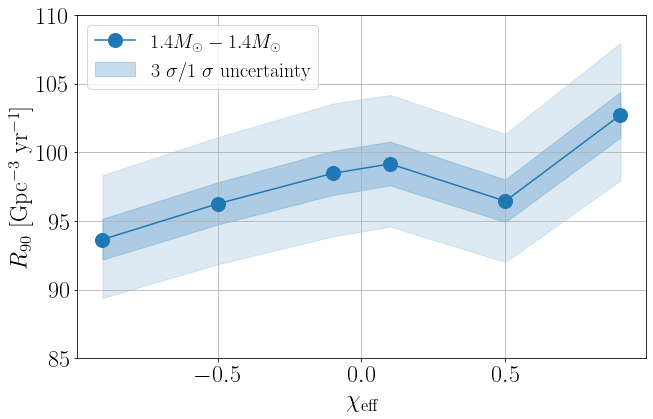

In [29]:
error = np.vstack(((rate-rate_low),(rate_high-rate)))
#plt.errorbar(chieffv,rate,yerr=error,fmt='o-', capsize=15,label='$1.4M_\odot - 1.4M_\odot$')
plt.plot(chieffv,rate,'-o',label='$1.4M_\odot - 1.4M_\odot$')
plt.fill_between(chieffv, rate_low, rate_high,alpha=0.25,color='tab:blue',label='3 $\sigma$/1 $\sigma$ uncertainty')
plt.fill_between(chieffv,rate_low_threesigma,rate_high_threesigma,alpha=0.15,color='tab:blue')

plt.xlabel('$\chi_\mathrm{eff}$')
plt.ylabel('$R_{90}$ [Gpc$^{-3}$ yr$^{-1}$]')
plt.legend(loc='upper left')
plt.ylim(85,110)
#plt.savefig('rate.png',bbox_inches='tight')

# Distance

In [30]:
chieffv = []
dist = []
dist_high = []
dist_low = []

for spinv in volume:
    chieffv.append(spinv)
    d,dhigh,dlow = volume_to_distance_with_errors(volume[spinv][0], volume[spinv][1])
    dist.append(d)
    dist_high.append(dhigh)
    dist_low.append(dlow)

In [31]:
dist,dist_high,dist_low

([182.38870965147865,
  180.73112769762307,
  179.3621661988259,
  178.9458403742138,
  180.60790609323314,
  176.85302665844017],
 [0.960904383660079,
  0.9583513447579719,
  0.9718158083009598,
  0.9542212400381516,
  0.9637366511286132,
  0.9494076789329142],
 [0.971137433694139,
  0.9686241589606084,
  0.982462433298366,
  0.9645079324492372,
  0.9741330368902652,
  0.9597121063503664])

In [39]:
np.savetxt('rate.txt',np.transpose([chieffv,rate,rate_low,rate_high,rate_low_threesigma,rate_high_threesigma]),
          fmt='%.3f',
          header='chi_eff rate rate_1sigma_low rate_1sigma_high rate_3sigma_low rate_3sigma_high')